# Possible ICx dendritic nonlinearities

This notebook runs the simulations and plots figures 4 and 5.

## Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
sns.set_style("white")

In [2]:
def Best_ITD(bF,Nitd):
    #bF are the best frequencies of the ICcl neurons (kHz)
    #Nitd is the number of best ITDs of the ICcl neurons at each BF 
    
    Nf = np.size(bF)
    
    bITD = np.zeros((Nf,Nitd))
    
    for n in np.arange(Nf):
        bITD[n,:] = np.linspace(-250,250,Nitd)
        
    return bITD    

In [3]:
def ICcl_Noise(ITD,bF,bITD):
    
    Nf,Nitd = np.shape(bITD)
  
    R = np.zeros((Nf,Nitd))
  
    for n in np.arange(Nf):
        
        b = (17 - np.sqrt(17**2 - 4*2.8*(24.12 - 2.44*bF[n])))/5.6 #From Fujita and Konishi 91
    
        I = np.cos(2*np.pi*bF[n]*(ITD - bITD[n,:])/1000) #assumes ITD, bITD are in us, bF in kHz
    
        R[n,:] = (np.exp(b*I)- np.exp(-b))/(np.exp(b) - np.exp(-b))
   
    return R

In [4]:
def half_width(x,y):
    #Subtract off minimum
    y = y - np.min(y)

    #Rectify
    y[y < 0] = 0
    
    #Normalize
    y = y/np.max(y)

    #Interpolate
    xi = np.linspace(np.min(x),np.max(x),1001,endpoint=True)
    yi = np.interp(xi, x, y)

    #Find the maximum value of y
    max_index = np.argmax(yi)

    BV = xi[max_index]

    #Cut it in half

    if max_index == 0:

        LL = np.min(xi)

        Ux = xi[max_index+1:]
        Uy = yi[max_index+1:]

        j = np.argmin(np.abs(Uy -.5))
        UL = np.min(Ux[j])
        
    elif max_index == np.size(xi)-1:

        Lx = xi[1:max_index-1]
        Ly = yi[1:max_index-1]


        j = np.argmin(np.abs(Ly-.5))
        LL = np.max(Lx[j])

        UL = np.size(xi)

    else:

        Lx = xi[1:max_index-1]
        Ly = yi[1:max_index-1]

        Ux = xi[max_index+1:]
        Uy = yi[max_index+1:]

        j = np.argmin(np.abs(Ly-.5))
        LL = np.max(Lx[j])


        j = np.argmin(np.abs(Uy -.5))
        UL = np.min(Ux[j])

    #Get half width

    HW=UL-LL
    
    return HW


In [5]:
def get_SPS(R):
    #R is the ITD tuning curve

    if np.max(R) > 0:
        index,_ = find_peaks(R)
        p = R[index]
        p = sorted(p,reverse=True)
        MP = p[0]
        
        if np.size(p) > 1:
            SP = p[1]
            SPS = 100*(MP - SP)/MP
            
    return SPS

### Functions for subunit model

In [6]:
def subunit_weights(CF,BW,bF,bITD,bF_sub,bITD_sub,sBF,sITD):
    #Sound properties: CF, BW
    #ICcl properties: bF, bITD
    #ICx subunit properties: bF_sub,bITD_sub,sBF,sITD
    
    Nf, Nitd = np.shape(bITD)

    #Get frequency weights
    Wf = np.exp(-.5*((bF - bF_sub)/sBF)**2)
    Wf[np.abs(bF - CF) > BW/2] = 0

    W = np.zeros((Nf,Nitd))
    for n in np.arange(Nitd):
        W[:,n] = Wf*np.exp(-.5*((bITD[:,n] - bITD_sub)/sITD)**2)
                       
    return W        

## Run simulation

In [7]:
##################################
#ICcl properties
Nf = 20
bF = np.linspace(.5,10,Nf)
  
Nitd = 30
bITD = Best_ITD(bF,Nitd)
##################################

##################################
#ICx fixed properties
bITD_sub = 0
sITD = 10

BF = 5
half_period = 1/BF*500

N_sub = 10
##################################

##################################
#Stimulus center frequency
CF = 5

#Max stimulus bandwidth
BW = 12

#Stimulus ITD
ITD = np.arange(-390,391,1)
L = np.size(ITD)
##################################

##################################
#Set up parameters to vary

#Subunit BF range
bw = np.linspace(0, 2.5, 3, endpoint=True)
Lbw = np.size(bw)

#Subunit weights width
sBF = np.linspace(.1, 4, 20, endpoint=True)
Ls = np.size(sBF)

#Subunit power
pw = np.arange(-10,11,1);pw = pw[(pw < -1) | (pw > 0)]
Lp = np.size(pw)

##################################

##################################

#Initialize parameters to measure
SPS = np.zeros((Lbw,Lp,Ls))
HW = np.zeros((Lbw,Lp,Ls))
ITD_curves = np.zeros((Lbw,Lp,Ls,L))

##################################

#Start by varying subunit BF range
for i in np.arange(Lbw):
    
    bF_sub = np.linspace(BF-bw[i],BF+bw[i],N_sub)
    
    #Next vary width of subunit frequency tuning
    for j in np.arange(Ls):
         
        #Initialize linear subunit response to ITD
        L_icx = np.zeros((N_sub,L))
        
        #Loop over subunits
        for k in np.arange(N_sub):
            
            #Get weights
            W = subunit_weights(CF,BW,bF,bITD,bF_sub[k],bITD_sub,sBF[j],sITD)
            
            #Get ITD tuning curve for linear part of subunit response
            for n in np.arange(L):
                #ICcl activities
                R_iccl = ICcl_Noise(ITD[n],bF,bITD)

                #Apply weights to ICcl activities
                L_icx[k,n] = np.sum(W*R_iccl)

        #Rectify
        L_icx[L_icx < 0] = 0
        
        #Apply different nonlinearities
        for l in np.arange(Lp):

            if pw[l] < 0:
                power = np.abs(1/pw[l])
            else:
                power = pw[l]

            #Subunit response    
            S_icx = L_icx**power

            #ICx subthreshold response
            V_icx = np.sum(S_icx,axis=0)
            
            
            #Collect normalized ITD curves            
            ITD_curves[i,l,j,:] = V_icx/np.max(V_icx)
            
            #If there is a response, measure SPS and HW
            if np.max(V_icx) > 0:
                
                V_icx = V_icx - np.min(V_icx)
                
                SPS[i,l,j] = get_SPS(V_icx)
                
                #remove side peaks before hw calculation
                max_index = np.argmax(V_icx)    
                V_icx[np.abs(ITD - ITD[max_index]) > half_period] = 0    

                HW[i,l,j] = half_width(ITD,V_icx)
                
            else: 
                SPS[i,l,j] = np.nan
                HW[i,l,j] = np.nan
                
 

### Example 1

In [8]:
sBF1 = 2.0
pw1 = -7.770833333333333

bF_sub1 = np.linspace(BF,BF,N_sub)


#Initialize linear subunit response to ITD
L_icx = np.zeros((N_sub,L))

#Loop over subunits
for k in np.arange(N_sub):
            
    #Get weights
    W = subunit_weights(CF,BW,bF,bITD,bF_sub1[k],bITD_sub,sBF1,sITD)
            
    #Get ITD tuning curve for linear part of subunit response
    for n in np.arange(L):
        #ICcl activities
        R_iccl = ICcl_Noise(ITD[n],bF,bITD)

        #Apply weights to ICcl activities
        L_icx[k,n] = np.sum(W*R_iccl)

#Rectify
L_icx[L_icx < 0] = 0


if pw1 < 0:
    power = np.abs(1/pw1)
else:
    power = pw1
       
#Subunit response    
S_icx = L_icx**power

#ICx subthreshold response
V_icx = np.sum(S_icx,axis=0)
            
            
#Collect normalized ITD curves            
ITD_curve1 = V_icx/np.max(V_icx)
            
#If there is a response, measure SPS and HW
if np.max(V_icx) > 0:
                
    V_icx = V_icx - np.min(V_icx)
                
    SPS1 = get_SPS(V_icx)
                
#remove side peaks before hw calculation
    max_index = np.argmax(V_icx)    
    V_icx[np.abs(ITD - ITD[max_index]) > half_period] = 0    

    HW1 = half_width(ITD,V_icx)
                
else: 
    SPS1 = np.nan
    HW1 = np.nan
                    

### Example 2

In [9]:
sBF2 = 0.8846153846153846
pw2 = 1.4916666666666667

bF_sub2 = np.linspace(BF,BF,N_sub)


#Initialize linear subunit response to ITD
L_icx = np.zeros((N_sub,L))

#Loop over subunits
for k in np.arange(N_sub):
            
    #Get weights
    W = subunit_weights(CF,BW,bF,bITD,bF_sub2[k],bITD_sub,sBF2,sITD)
            
    #Get ITD tuning curve for linear part of subunit response
    for n in np.arange(L):
        #ICcl activities
        R_iccl = ICcl_Noise(ITD[n],bF,bITD)

        #Apply weights to ICcl activities
        L_icx[k,n] = np.sum(W*R_iccl)

#Rectify
L_icx[L_icx < 0] = 0


if pw2 < 0:
    power = np.abs(1/pw2)
else:
    power = pw2
       
#Subunit response    
S_icx = L_icx**power

#ICx subthreshold response
V_icx = np.sum(S_icx,axis=0)
            
            
#Collect normalized ITD curves            
ITD_curve2 = V_icx/np.max(V_icx)
            
#If there is a response, measure SPS and HW
if np.max(V_icx) > 0:
                
    V_icx = V_icx - np.min(V_icx)
                
    SPS2 = get_SPS(V_icx)
                
#remove side peaks before hw calculation
    max_index = np.argmax(V_icx)    
    V_icx[np.abs(ITD - ITD[max_index]) > half_period] = 0    

    HW2 = half_width(ITD,V_icx)
                
else: 
    SPS2 = np.nan
    HW2 = np.nan
                    

## Figures

### Figure 4

In [10]:
power2 = []

for l in np.arange(Lp):

    if pw[l] < 0:
        power2.append(np.abs(1/pw[l]))
    else:
        power2.append(pw[l])
        
power2        

[0.1,
 0.1111111111111111,
 0.125,
 0.14285714285714285,
 0.16666666666666666,
 0.2,
 0.25,
 0.3333333333333333,
 0.5,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10]

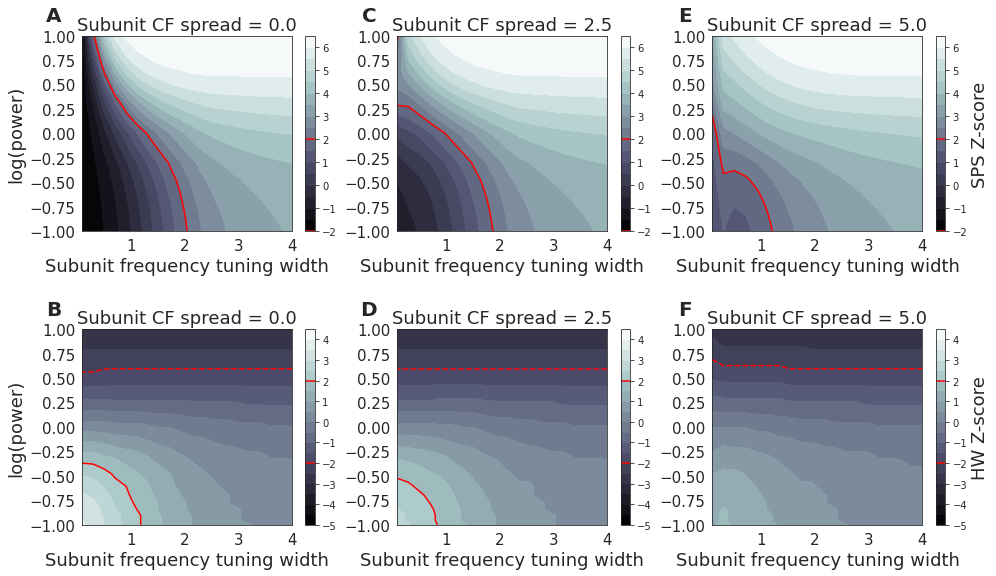

In [11]:
labels = ('A', 'C', 'E', 'B', 'D', 'F')

#Plot SPS

#Convert SPS to z-scores
mu = 23.18
sig = 12.27

fig1 = plt.figure(figsize = (16,9))


for n in np.arange(Lbw):
    
    sps = SPS[n,:,:]
    Z = (sps - mu)/sig

    #Contour map
    ax2 = plt.subplot(2,3,n+1)
    
    ax2.text(-0.1, 1.15, labels[n], transform=ax2.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')
    

    line_levels = np.arange(-2,7,.5)
    CS = ax2.contourf(sBF,np.log10(power2),Z, 10, levels = line_levels, cmap='bone', origin='lower')

    #Figure labels
    ax2.set_title('Subunit CF spread = ' + str(bw[n]*2),fontsize = 18)
    ax2.set_xlabel('Subunit frequency tuning width',fontsize = 18)
    if n == 0:
        ax2.set_ylabel('log(power)',fontsize = 18)

    # Make a colorbar for the ContourSet returned by the contourf call.
    cbar = fig1.colorbar(CS)
    if n == Lbw-1:
        cbar.ax.set_ylabel('SPS Z-score',fontsize = 18)

    # Add the contour line levels to the colorbar
    line_levels = [-2, 2]
    #CS2 = ax2.contour(CS, levels = line_levels, colors='r', origin=origin)
    CS2 = ax2.contour(CS, levels = line_levels, colors='r', origin='lower')
    cbar.add_lines(CS2)

    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    
#Plot HW

#Convert HW to z-scores
mu = 75.17
sig = 17.12


for n in np.arange(Lbw):
    
    X = HW[n,:,:]
    Z = (X - mu)/sig

    #Contour map
    ax2 = plt.subplot(2,Lbw,n+4)
        
    ax2.text(-0.1, 1.15, labels[n+3], transform=ax2.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')

    
    line_levels = np.arange(-5,5,.5)
    CS = ax2.contourf(sBF,np.log10(power2),Z, 10, levels = line_levels, cmap='bone', origin='lower')

    #Figure labels
    ax2.set_title('Subunit CF spread = ' + str(bw[n]*2),fontsize = 18)
    ax2.set_xlabel('Subunit frequency tuning width',fontsize = 18)
    if n == 0:
        ax2.set_ylabel('log(power)',fontsize = 18)

    # Make a colorbar for the ContourSet returned by the contourf call.
    cbar = fig1.colorbar(CS)
    if n == Lbw-1:
        cbar.ax.set_ylabel('HW Z-score',fontsize = 18)

    # Add the contour line levels to the colorbar
    line_levels = [-2, 2]
    CS2 = ax2.contour(CS, levels = line_levels, colors='r', origin='lower')
    cbar.add_lines(CS2)
    
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)


#from google.colab import files
#files.download("Figure4.png")


plt.show()

### Figure 5

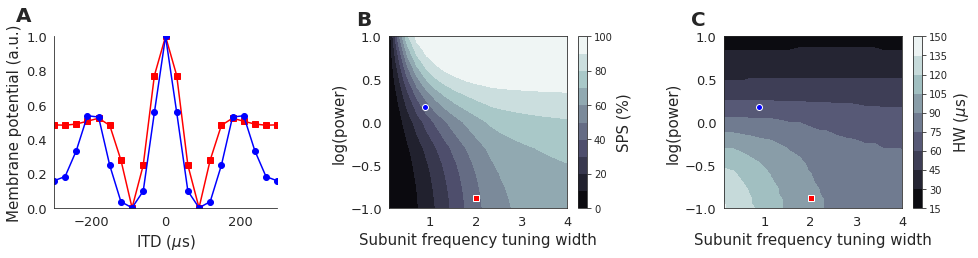

In [12]:
#Similar ITD tuning with different models

fig1 = plt.figure(figsize = (16,3.5))


fs = 15
ts = 13

labels = ('A', 'B', 'C')

n_bw = 0

index = np.arange(0,L,30)


y1 = ITD_curve1
y1 = y1[index]
y1 = y1 - np.min(y1); y1 = y1/np.max(y1)

y2 = ITD_curve2
y2 = y2[index]
y2 = y2 - np.min(y2); y2 = y2/np.max(y2)


ax2 = plt.subplot(1,3,1)
ax2.text(-0.1, 1.175, labels[0], transform=ax2.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')




plt.plot(ITD[index],y1,'r-s')
plt.plot(ITD[index],y2,'b-o')

ax2.set_xlabel('ITD ($\mu$s)',fontsize = fs)
ax2.set_ylabel('Membrane potential (a.u.)',fontsize = fs)

plt.tick_params(labelsize = ts)
plt.ylim(0,1)
plt.xlim(-300,300)


ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

sps = SPS[n_bw,:,:]
hw = HW[n_bw,:,:]

ax2 = plt.subplot(1,3,3)
ax2.text(-0.1, 1.15, labels[2], transform=ax2.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')

CS = ax2.contourf(sBF,np.log10(power2),hw, 10, cmap='bone', origin='lower')

#Figure labels
ax2.set_xlabel('Subunit frequency tuning width',fontsize = fs)
ax2.set_ylabel('log(power)',fontsize = fs)

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('HW ($\mu$s)',fontsize = fs)


plt.plot(sBF1,np.log10(-1/pw1),'rs',mec = 'w')
plt.plot(sBF2,np.log10(pw2),'bo',mec = 'w')
plt.tick_params(labelsize = ts)


ax2 = plt.subplot(1,3,2)
ax2.text(-0.1, 1.15, labels[1], transform=ax2.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')

CS = ax2.contourf(sBF,np.log10(power2),sps, 10, cmap='bone', origin='lower')

#Figure labels
ax2.set_xlabel('Subunit frequency tuning width',fontsize = fs)
ax2.set_ylabel('log(power)',fontsize = fs)

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('SPS (%)',fontsize = fs)


plt.plot(sBF1,np.log10(-1/pw1),'rs',mec = 'w')
plt.plot(sBF2,np.log10(pw2),'bo',mec = 'w')
plt.tick_params(labelsize = ts)

plt.subplots_adjust(wspace = 0.5)
plt.gcf().subplots_adjust(bottom=0.2)

#from google.colab import files
#files.download("Figure5.png")

plt.show()